# Price Elasticity & Markdown Simulation

In [1]:
# Import necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('online_retail_II.xlsx')

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [5]:
# Remove negative values from the quantites column
df = df[df['Quantity']>0]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 513135 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      513135 non-null  object        
 1   StockCode    513135 non-null  object        
 2   Description  512034 non-null  object        
 3   Quantity     513135 non-null  int64         
 4   InvoiceDate  513135 non-null  datetime64[ns]
 5   Price        513135 non-null  float64       
 6   Customer ID  407695 non-null  float64       
 7   Country      513135 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 35.2+ MB


In [7]:
# remove missing values in the Stockvode and Price column
df = df.dropna(subset=['StockCode','Price'])  

<Axes: xlabel='Price'>

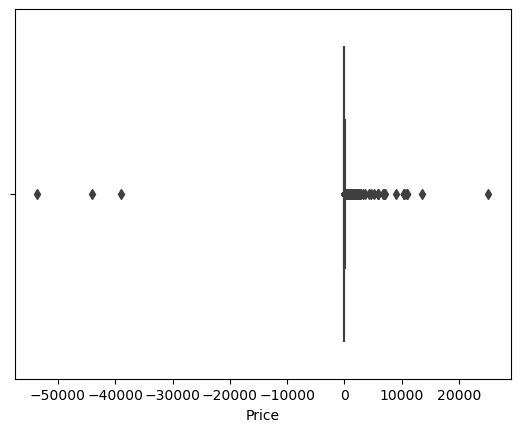

In [8]:
sns.boxplot(x=df['Price'])

In [9]:
# Trim unrealistic prices 
df = df[(df['Price']>=0.01) & (df['Price']<=10000)]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 511545 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      511545 non-null  object        
 1   StockCode    511545 non-null  object        
 2   Description  511545 non-null  object        
 3   Quantity     511545 non-null  int64         
 4   InvoiceDate  511545 non-null  datetime64[ns]
 5   Price        511545 non-null  float64       
 6   Customer ID  407648 non-null  float64       
 7   Country      511545 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 35.1+ MB


<Axes: xlabel='Price'>

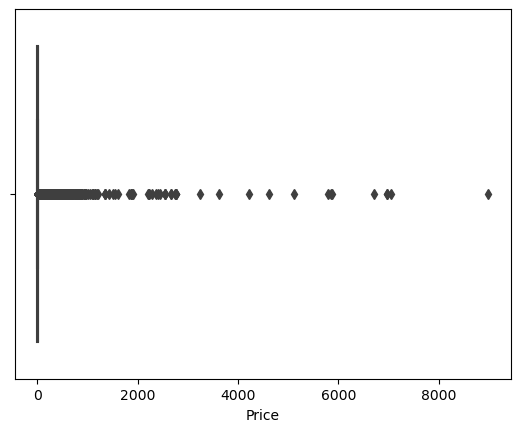

In [11]:
sns.boxplot(x=df['Price'])

In [12]:
# Create date features
df['date'] = pd.to_datetime(df['InvoiceDate']).dt.date
df['year'] = pd.to_datetime(df['InvoiceDate']).dt.year
df['month'] = pd.to_datetime(df['InvoiceDate']).dt.month
df['week'] = pd.to_datetime(df['InvoiceDate']).dt.to_period('W').apply(lambda r: r.start_time)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 511545 entries, 0 to 525460
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      511545 non-null  object        
 1   StockCode    511545 non-null  object        
 2   Description  511545 non-null  object        
 3   Quantity     511545 non-null  int64         
 4   InvoiceDate  511545 non-null  datetime64[ns]
 5   Price        511545 non-null  float64       
 6   Customer ID  407648 non-null  float64       
 7   Country      511545 non-null  object        
 8   date         511545 non-null  object        
 9   year         511545 non-null  int32         
 10  month        511545 non-null  int32         
 11  week         511545 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int32(2), int64(1), object(5)
memory usage: 46.8+ MB


In [14]:
# Country-level EDA
country_summary = df.groupby("Country").agg(
    total_revenue=("Price", lambda x: (x * df.loc[x.index, 'Quantity']).sum()),
    total_units=("Quantity", "sum"),
    n_invoices=("Invoice", "nunique")
).sort_values("total_revenue", ascending=False)

print("\nTOP 10 COUNTRIES BY REVENUE:")
print(country_summary.head(10))


TOP 10 COUNTRIES BY REVENUE:
                total_revenue  total_units  n_invoices
Country                                               
United Kingdom     8754163.43      4720835       19284
EIRE                380977.82       193116         348
Netherlands         268786.00       183616         135
Germany             202395.32       108721         347
France              147211.49       163183         241
Sweden               53525.39        52567          69
Denmark              50906.85       229690          26
Spain                47601.42        22856          66
Switzerland          43921.39        22255          40
Australia            31446.80        20189          40


In [15]:
# SKU-level EDA
sku_stats_full = df.groupby(['StockCode', 'Description']).agg(
    total_units=('Quantity', 'sum'),
    total_revenue=('Price', lambda s: (s * df.loc[s.index, 'Quantity']).sum()),
    avg_price=('Price', 'mean'),
    price_volatility=('Price', 'std'),
    n_transactions=('Invoice', 'nunique')
).reset_index()

print("\nTOP 10 SKUs BY UNITS:")
print(sku_stats_full.sort_values("total_units", ascending=False).head(10))


TOP 10 SKUs BY UNITS:
     StockCode                         Description  total_units  \
4271    85123A  WHITE HANGING HEART T-LIGHT HOLDER        58487   
2722     84077   WORLD WAR 2 GLIDERS ASSTD DESIGNS        55091   
52       17003                 BROCADE RING PURSE         48374   
533      21212    PACK OF 72 RETRO SPOT CAKE CASES        46755   
2892     84879       ASSORTED COLOUR BIRD ORNAMENT        45348   
2938     84991         60 TEATIME FAIRY CAKE CASES        36502   
1238     21977  PACK OF 60 PINK PAISLEY CAKE CASES        31940   
4254    85099B             JUMBO BAG RED RETROSPOT        30386   
1455     22197                SMALL POPCORN HOLDER        29788   
554      21232      STRAWBERRY CERAMIC TRINKET BOX        27127   

      total_revenue  avg_price  price_volatility  n_transactions  
4271      158590.87   3.047051          0.757929            3281  
2722       11418.05   0.243972          0.060786             501  
52          8922.80   0.240513        

In [16]:
df['date'] = pd.to_datetime(df['InvoiceDate']).dt.date
df['year'] = pd.to_datetime(df['InvoiceDate']).dt.year
df['month'] = pd.to_datetime(df['InvoiceDate']).dt.month
df['week'] = pd.to_datetime(df['InvoiceDate']).dt.to_period('W').apply(lambda r: r.start_time)

In [17]:
# Daily
daily = df.groupby("date").agg(
    daily_units=('Quantity', 'sum'),
    daily_revenue=('Price', lambda s: (s * df.loc[s.index, 'Quantity']).sum())
).reset_index()
daily.to_csv("C:/Users/DELL/Documents/november project/daily_summary.csv", index=False)

In [18]:
# Weekly
weekly = df.groupby("week").agg(
    weekly_units=('Quantity', 'sum'),
    weekly_revenue=('Price', lambda s: (s * df.loc[s.index, 'Quantity']).sum())
).reset_index()
weekly.to_csv("C:/Users/DELL/Documents/november project/weekly_summary.csv", index=False)

In [19]:
# Monthly
monthly = df.groupby(['year', 'month']).agg(
    monthly_units=('Quantity', 'sum'),
    monthly_revenue=('Price', lambda s: (s * df.loc[s.index, 'Quantity']).sum())
).reset_index()
monthly.to_csv("C:/Users/DELL/Documents/november project/monthly_summary.csv", index=False)

In [20]:
print(f'\nTIME-BASED AGGREGATIONS SAVED (daily, weekly, monthly)')


TIME-BASED AGGREGATIONS SAVED (daily, weekly, monthly)


C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(array([14610., 14669., 14730., 14791., 14853., 14914.]),
 [Text(14610.0, 0, '2010-01'),
  Text(14669.0, 0, '2010-03'),
  Text(14730.0, 0, '2010-05'),
  Text(14791.0, 0, '2010-07'),
  Text(14853.0, 0, '2010-09'),
  Text(14914.0, 0, '2010-11')])

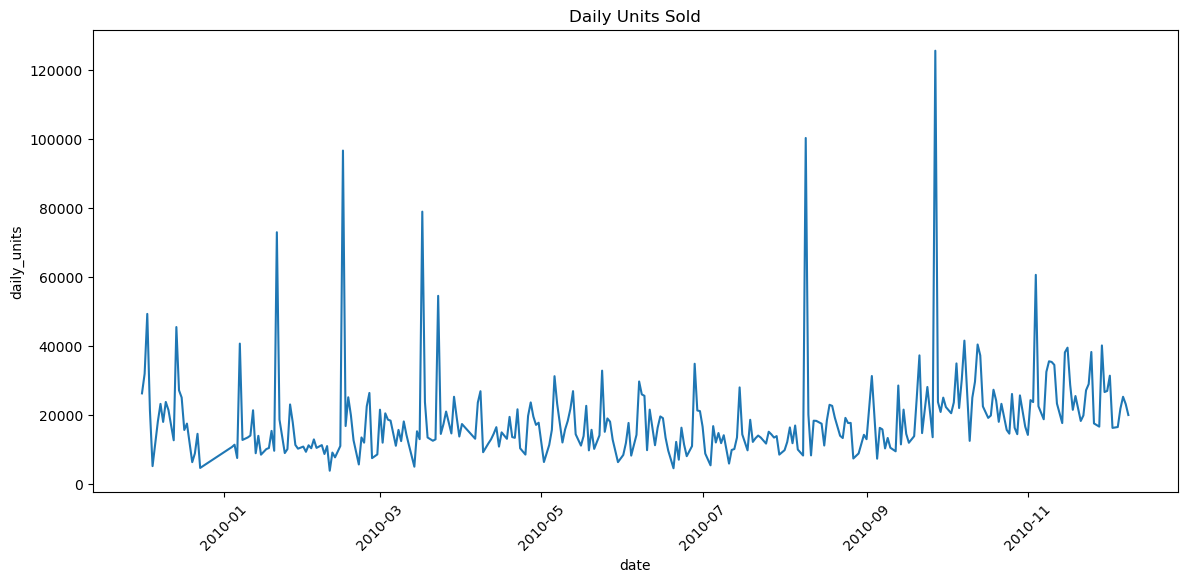

In [21]:
# === Daily Units ===
plt.figure(figsize=(14,6))
sns.lineplot(data=daily, x="date", y="daily_units")
plt.title("Daily Units Sold")
plt.xticks(rotation=45)

C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(array([14610., 14669., 14730., 14791., 14853., 14914.]),
 [Text(14610.0, 0, '2010-01'),
  Text(14669.0, 0, '2010-03'),
  Text(14730.0, 0, '2010-05'),
  Text(14791.0, 0, '2010-07'),
  Text(14853.0, 0, '2010-09'),
  Text(14914.0, 0, '2010-11')])

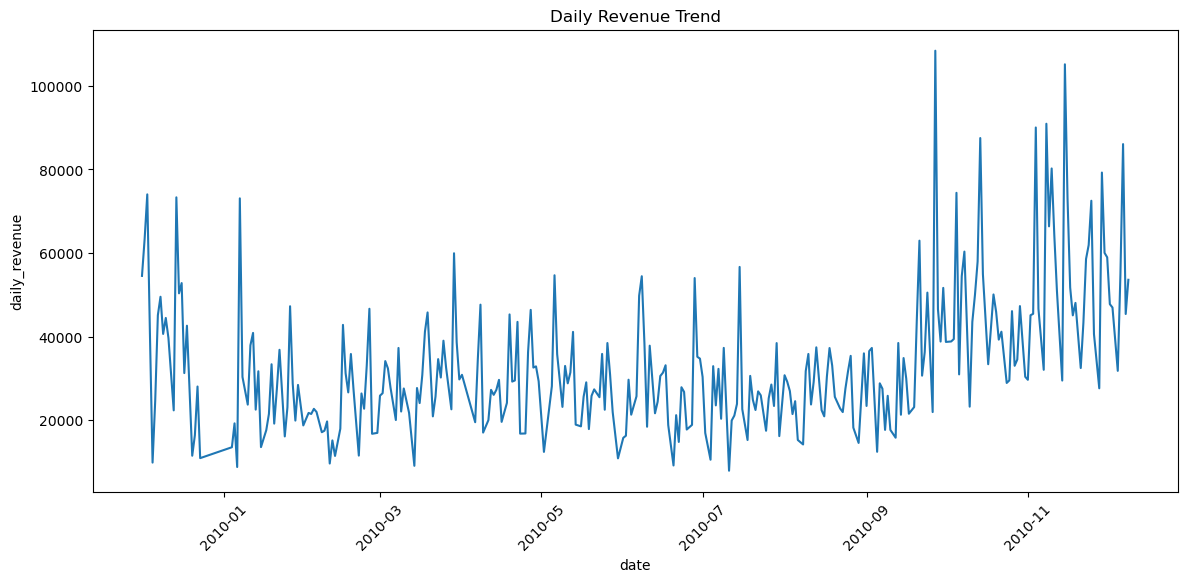

In [22]:
# === Daily Revenue ===
plt.figure(figsize=(14,6))
sns.lineplot(data=daily, x="date", y="daily_revenue")
plt.title("Daily Revenue Trend")
plt.xticks(rotation=45)

C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Weekly Units Sold')

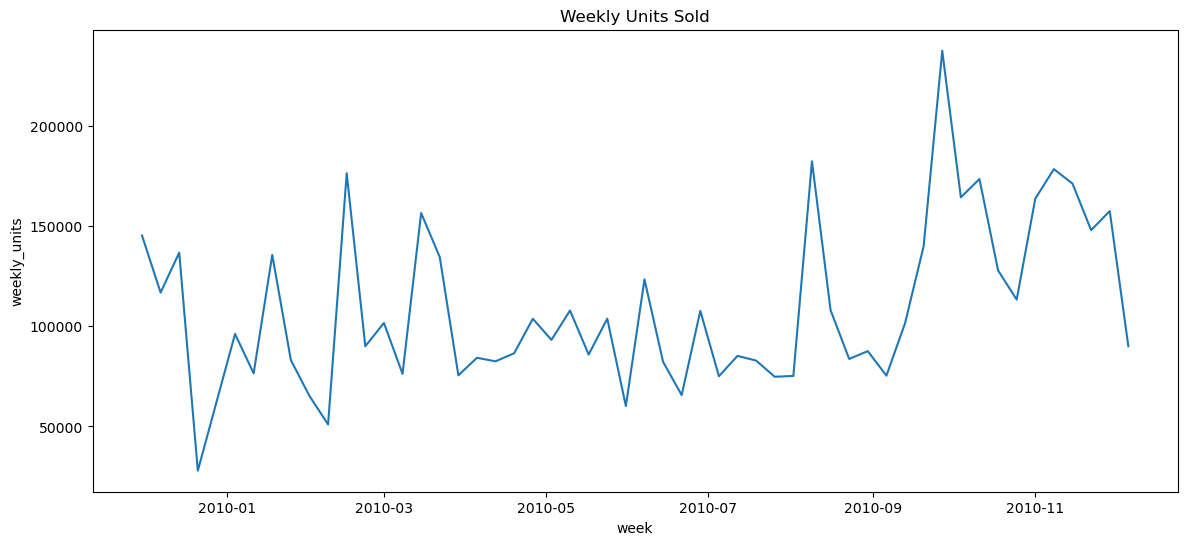

In [23]:
# === Weekly Units ===
plt.figure(figsize=(14,6))
sns.lineplot(data=weekly, x="week", y="weekly_units")
plt.title("Weekly Units Sold")

C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Weekly Revenue Trend')

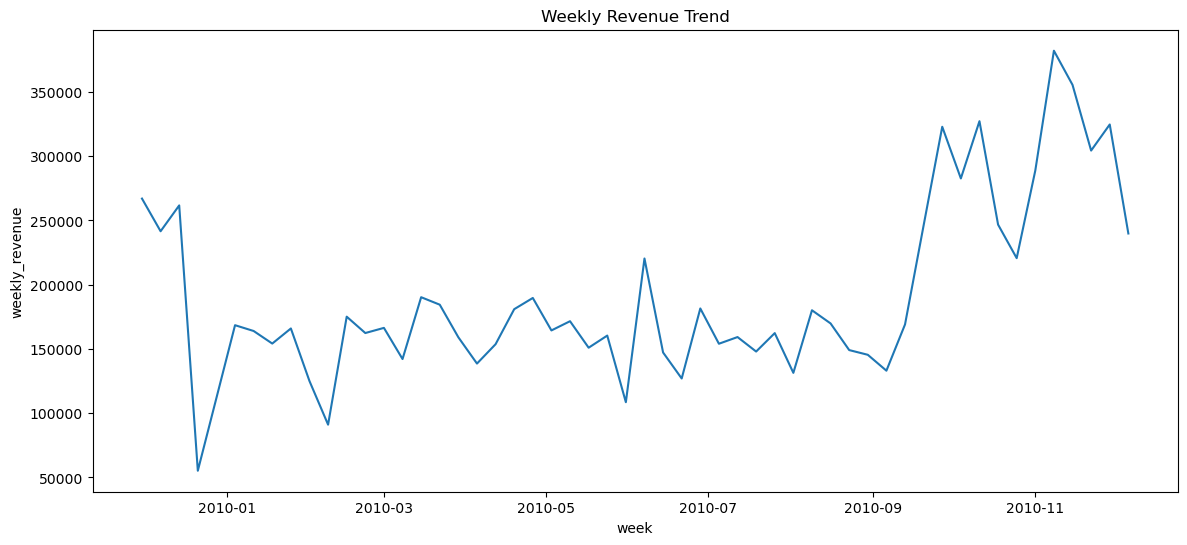

In [24]:
# === Weekly Revenue ===
plt.figure(figsize=(14,6))
sns.lineplot(data=weekly, x="week", y="weekly_revenue")
plt.title("Weekly Revenue Trend")

C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Monthly Revenue (Yearly Overlay)')

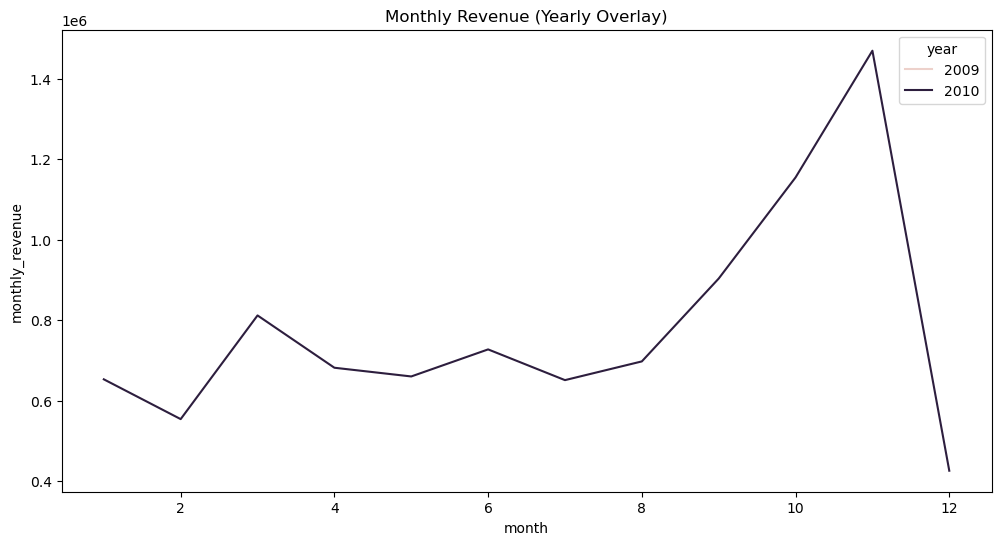

In [25]:
# === Monthly Revenue ===
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly, x="month", y="monthly_revenue", hue="year")
plt.title("Monthly Revenue (Yearly Overlay)")

Text(0.5, 1.0, 'Price vs Quantity — SKU 85123A')

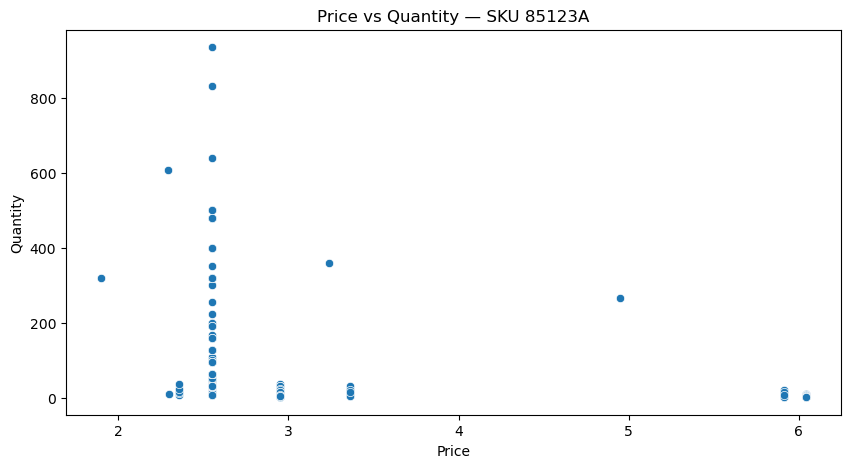

In [26]:
# SKU PRICE–DEMAND VISUAL SAMPLE
sample_sku = sku_stats_full.sort_values("total_units", ascending=False).iloc[0]['StockCode']
df_sku = df[df['StockCode'] == sample_sku]

plt.figure(figsize=(10,5))
sns.scatterplot(data=df_sku, x='Price', y='Quantity')
plt.title(f"Price vs Quantity — SKU {sample_sku}")


CORRELATION MATRIX:
          Quantity     Price
Quantity  1.000000 -0.008296
Price    -0.008296  1.000000


Text(0.5, 1.0, 'Correlation Matrix (Quantity vs Price)')

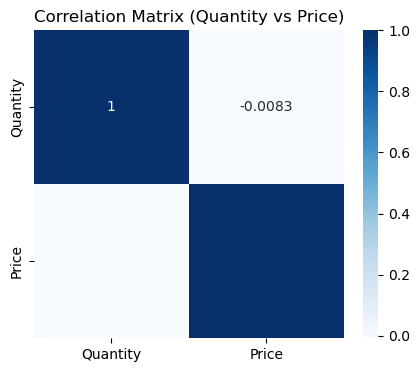

In [27]:
# 12. CORRELATION
corr_df = df[['Quantity','Price']]
print("\nCORRELATION MATRIX:")
print(corr_df.corr())

plt.figure(figsize=(5,4))
sns.heatmap(corr_df.corr(), annot=True, cmap="Blues")
plt.title("Correlation Matrix (Quantity vs Price)")

In [28]:
# 13. WEEKLY PER-SKU AGGREGATION
temp = df.copy()
temp['revenue'] = temp['Price'] * temp['Quantity']

agg = temp.groupby(['StockCode','week']).agg(
    units=('Quantity','sum'),
    revenue=('revenue','sum'),
    avg_price=('Price', lambda s: np.average(s, weights=temp.loc[s.index,'Quantity'])),
    n_invoices=('Invoice','nunique')
).reset_index()

agg.to_csv("C:/Users/DELL/Documents/november project/sku_weekly_agg.csv", index=False)

In [29]:
# 14. CANDIDATE SKUs FOR ELASTICITY
sku_stats = agg.groupby('StockCode').agg(
    total_units=('units','sum'),
    weeks_present=('week','nunique'),
    mean_price=('avg_price','mean'),
    price_std=('avg_price','std'),
    price_cv=('avg_price', lambda x: x.std()/x.mean() if x.mean()!=0 else 0)
).reset_index()

candidate_skus = sku_stats[
    (sku_stats['total_units'] >= 500) &
    (sku_stats['weeks_present'] >= 10) &
    (sku_stats['price_cv'] >= 0.05)
].sort_values('total_units', ascending=False)

print("\nCANDIDATE SKUs IDENTIFIED:", candidate_skus.shape[0])
candidate_skus.to_csv("C:/Users/DELL/Documents/november project/candidate_skus.csv", index=False)


CANDIDATE SKUs IDENTIFIED: 1641


# Per SKU Elasticity Estimation

In [30]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.utils import resample

In [31]:
def estimate_loglog_ols(df_ts, price_col='avg_price', qty_col='units', controls=None):
    """
    df_ts: dataframe for a single SKU aggregated by period (week)
    Returns: fitted model, elasticity estimate (beta on log(price)), bootstrap CI
    """
    df = df_ts.copy().dropna(subset=[price_col, qty_col])
    # filter out zero units (can't log), replace tiny zeros with small number if needed
    df = df[df[qty_col]>0]
    df['log_q'] = np.log(df[qty_col])
    df['log_p'] = np.log(df[price_col])
    # promo flag: price < historical median * 0.95
    df['promo_flag'] = (df[price_col] < df[price_col].median()*0.95).astype(int)
    # seasonality: month or weekofyear
    df['month'] = pd.to_datetime(df['week']).dt.month
    # build formula
    formula = 'log_q ~ log_p + promo_flag + C(month)'
    model = smf.ols(formula=formula, data=df).fit(cov_type='HC3')  # heteroskedasticity robust
    # get elasticity (coefficient on log_p)
    beta = model.params.get('log_p', np.nan)
    # bootstrap CI for beta
    n_boot = 500
    boots = []
    for i in range(n_boot):
        sample = df.sample(frac=1, replace=True)
        try:
            m = smf.ols(formula=formula, data=sample).fit()
            boots.append(m.params.get('log_p'))
        except Exception:
            continue
    ci_lower = np.percentile(boots, 2.5) if len(boots)>0 else np.nan
    ci_upper = np.percentile(boots, 97.5) if len(boots)>0 else np.nan
    return {'model': model, 'elasticity': beta, 'ci':(ci_lower,ci_upper), 'n_obs':len(df)}

In [32]:
results = []
for sku in candidate_skus['StockCode'].unique()[:50]:  # limit to top 50 by volume to save time
    ts = agg[agg['StockCode']==sku].sort_values('week')
    if len(ts) < 8: continue
    r = estimate_loglog_ols(ts)
    results.append({
        'StockCode': sku,
        'elasticity': r['elasticity'],
        'ci_lower': r['ci'][0],
        'ci_upper': r['ci'][1],
        'n_obs': r['n_obs']
    })
res_df = pd.DataFrame(results).sort_values('n_obs', ascending=False)
res_df.to_csv('C:/Users/DELL/Documents/november project/elasticity_estimates.csv', index=False)

# Small Gradient-Boosted baseline for predictive comparison

In [33]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb

In [34]:
def gbt_predictive_baseline(df_ts):
    # Features: log_price, promo_flag, month, lagged demand
    df = df_ts.copy().sort_values('week')
    df = df[df['units']>0]
    df['log_p'] = np.log(df['avg_price'])
    df['promo_flag'] = (df['avg_price'] < df['avg_price'].median()*0.95).astype(int)
    df['month'] = pd.to_datetime(df['week']).dt.month
    # Lag features
    for lag in [1,2,4]:
        df[f'lag_{lag}'] = df['units'].shift(lag)
    df = df.dropna()
    features = ['log_p','promo_flag','month','lag_1','lag_2','lag_4']
    X = df[features]
    y = df['units']
    tscv = TimeSeriesSplit(n_splits=3)
    rmses, maes = [], []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        dtrain = lgb.Dataset(X_train, label=y_train)
        params = {'objective':'regression','metric':'rmse','verbosity':-1}
        bst = lgb.train(params, dtrain, num_boost_round=100)
        preds = bst.predict(X_test)
        rmses.append(np.sqrt(mean_squared_error(y_test, preds)))
        maes.append(mean_absolute_error(y_test, preds))
    return {'rmse': np.mean(rmses), 'mae': np.mean(maes)}

# Markdown Simulation & price optimisation

In [35]:
def revenue_for_price_grid(elasticity, C, price_grid):
    # demand = C * p^elasticity
    demand = C * (price_grid ** elasticity)
    revenue = price_grid * demand
    return demand, revenue

def find_revenue_max_price(elasticity_est, elasticity_boots, C, p0,
                           floor_price=None, ceil_price=None,
                           down_pct=0.3, up_pct=0.2, step=0.01):
    # define grid
    if floor_price is None:
        floor_price = p0*(1-down_pct)
    if ceil_price is None:
        ceil_price = p0*(1+up_pct)
    grid = np.arange(floor_price, ceil_price+1e-9, step)
    # point estimate
    _, rev = revenue_for_price_grid(elasticity_est, C, grid)
    best_idx = np.nanargmax(rev)
    best_price = grid[best_idx]
    best_revenue = rev[best_idx]
    # uncertainty: compute revenue for many bootstrap elasticities and get quantiles of revenue-max price
    best_prices_boot = []
    for b in elasticity_boots:
        _, revb = revenue_for_price_grid(b, C, grid)
        best_prices_boot.append(grid[np.nanargmax(revb)])
    lower = np.percentile(best_prices_boot, 2.5)
    upper = np.percentile(best_prices_boot, 97.5)
    return {'best_price':best_price, 'best_revenue':best_revenue, 'price_ci':(lower,upper), 'grid':grid, 'rev_grid':rev}